# Train an anti-aliased U-net based GAN

## Imports and GPU identification

In [1]:
import tensorflow as tf
import os
from PIL import Image
from scipy import special
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib
from datetime import datetime

print(device_lib.list_local_devices())
print(tf.config.experimental.get_memory_info("/device:GPU:0")['current'])

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7046638730192803894
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2258055988
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7223852161758365009
physical_device_desc: "device: 0, name: Quadro T1000, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
0


## Circularly symmetric low-pass or anti-aliasing filter
The filter will be tested after configuration.

In [2]:
def circular_lowpass_kernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size.
    with np.errstate(divide='ignore',invalid='ignore'):    
        kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N])
    if N % 2:
        kernel[(N - 1)//2, (N - 1)//2] = omega_c**2/(4*np.pi)
    return kernel

def rotated_cosine_window(N):  # N = horizontal size of the targeted kernel, also its vertical size, must be odd.
    return np.fromfunction(lambda y, x: np.maximum(np.cos(np.pi/2*np.sqrt(((x - (N - 1)/2)/((N - 1)/2 + 1))**2 + ((y - (N - 1)/2)/((N - 1)/2 + 1))**2)), 0), [N, N])

def windowed_circular_lowpass_kernel(cutoff, kernel_size):
    return (circular_lowpass_kernel(cutoff, kernel_size)*rotated_cosine_window(kernel_size)).astype(np.float32);

def test_kernel(kernel):
    kernel_size = kernel.shape[0] #height, should be same as width
    
    print("Kernel:")
    plt.imshow(kernel, vmin=-0.25, vmax=0.25, cmap='bwr', extent=[-kernel_size/2, kernel_size/2, -kernel_size/2, kernel_size/2])
    plt.colorbar()
    plt.show()

    print("Frequency response:")
    freq_resp = np.real(np.fft.fftshift(np.fft.fft2(np.roll(np.pad(kernel, 100, mode = 'constant', constant_values = 0), shift = (-kernel_size//2-99, -kernel_size//2-99), axis = (0, 1)))))
    plt.imshow(freq_resp, vmin=-1.2, vmax=1.2, cmap='bwr', extent=[-np.pi, np.pi, -np.pi, np.pi])
    plt.colorbar()
    plt.show()

## Load training target images and low-pass filter them

Note: Do NOT use the filtered PNG images as network input, because they have been quantized. They can be saved for visual inspection.

Kernel:


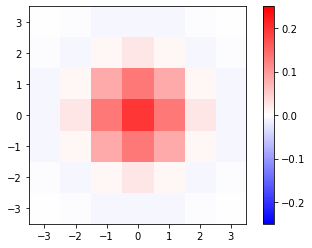

Frequency response:


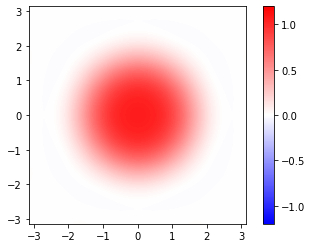

Batch size = 100


In [6]:
# Configuration
oversampling = 2  # Oversampling factor, 2 is a good choice
aa_kernel_size = 7  # Horizontal size of the kernel, also its vertical size. 9 is a good choice when oversampling == 2.
approx_batch_size = 100
train_image_cropped_size = 256
photos_dir = "D:/roman/source_grass_images_subset"
save_filtered_photos_dir = "D:/roman/filtered_grass_images_subset" # save folder, or None to disable saving

test_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_kernel_size))

def channeled_kernel(kernel_prototype, num_channels):
    kernel_expanded = tf.expand_dims(kernel_prototype, 2)
    kernel_repeated = tf.repeat(kernel_expanded, num_channels, axis=2)
    return tf.expand_dims(kernel_repeated, -1)

def load_and_filter_image(filepath, channeled_kernel):
    image = tf.io.decode_png(tf.io.read_file(filepath), channels=3, dtype=tf.dtypes.uint8)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) * 2 - 1
    image = tf.nn.depthwise_conv2d([image], channeled_kernel, [1, 1, 1, 1], "VALID")[0]
    if save_filtered_photos_dir is not None:
        basename = tf.py_function(lambda string_tensor: os.path.basename(string_tensor.numpy()), [filepath], tf.string)
        tf.io.write_file(save_filtered_photos_dir + "/" + basename, tf.io.encode_png(tf.image.convert_image_dtype((image + 1)/2, dtype=tf.dtypes.uint8, saturate=True)))
    return image

train_dataset = tf.data.Dataset.list_files(photos_dir + "/*.png")
train_dataset = train_dataset.map(lambda filepath: load_and_filter_image(filepath, channeled_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_kernel_size), 3)), num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
train_dataset = train_dataset.cache() # Load photos now instead of doing it again for each copy made in the next line
train_dataset = train_dataset.repeat(tf.math.floordiv(approx_batch_size, train_dataset.cardinality()))
train_dataset = train_dataset.cache()

batch_size = train_dataset.cardinality() # batch size
print("Batch size = " + str(batch_size.numpy()))

## Isotropically lowpass filtered upsample layer
This layer will double the feature map resolution and apply a circularly symmmetrical lowpass filter

Test input:


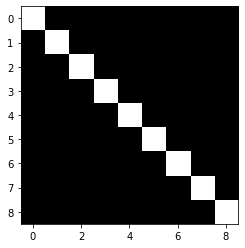

Isotropically lowpass filtered:


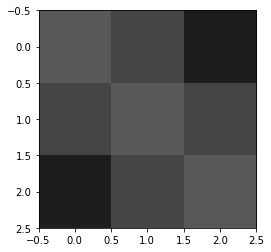

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Isotropically lowpass filtered upsampled:


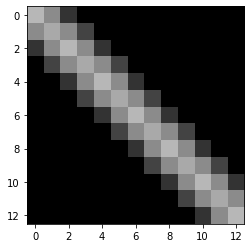

In [7]:
class IsotropicalLowpassFilterLayer(tf.keras.layers.Layer):
    def __init__(self, cutoff, kernel_size, padding='valid'):
        super(IsotropicalLowpassFilterLayer, self).__init__()
        self.kernel_prototype = windowed_circular_lowpass_kernel(cutoff, kernel_size)
        self.kernel_size = kernel_size
        self.padding = padding
        
    def build(self, input_shape):
        self.filtering = tf.keras.layers.DepthwiseConv2D(self.kernel_size, trainable=False, strides=1, padding=self.padding, use_bias=False, weights=[channeled_kernel(self.kernel_prototype, input_shape[-1])])

    def call(self, inputs):
        return self.filtering(inputs)

def get_upsample_multiplication_tensor(input_shape):
    tile = tf.constant([[0, 0], [0, 4]], dtype=tf.float32)
    return tf.reshape(tf.tile(tile, [input_shape[-3], input_shape[-2]]), (1, input_shape[-3]*2, input_shape[-2]*2, 1))

class IsotropicallyLowpassFilteredUpsampleLayer(tf.keras.layers.Layer):
    def __init__(self, cutoff, kernel_size, padding='valid'):
        super(IsotropicallyLowpassFilteredUpsampleLayer, self).__init__()
        self.upsampling = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation='nearest')
        self.multiply = tf.keras.layers.Multiply()
        self.zeropadding = tf.keras.layers.ZeroPadding2D(padding = ((0, 1), (0, 1)))        
        self.kernel_prototype = windowed_circular_lowpass_kernel(cutoff, kernel_size)
        self.kernel_size = kernel_size
        self.padding = padding
        
    def build(self, input_shape):
        self.multiplication_tensor = get_upsample_multiplication_tensor(input_shape)
        self.filtering = tf.keras.layers.DepthwiseConv2D(self.kernel_size, trainable=False, strides=1, padding=self.padding, use_bias=False, weights=[channeled_kernel(self.kernel_prototype, input_shape[-1])])

    def call(self, inputs):
        x = self.upsampling(inputs)
        x = self.multiply([x, self.multiplication_tensor])
        x = self.zeropadding(x)
        x = self.filtering(x)
        return x    
    
print("Test input:")
input_shapes = (aa_kernel_size + 2, aa_kernel_size + 2, 3)
eye = tf.repeat(tf.expand_dims(tf.repeat(tf.expand_dims(tf.eye(input_shapes[0], input_shapes[1]), -1), repeats = input_shapes[2], axis = -1), 0), repeats = batch_size, axis = 0)
plt.imshow(eye[0])
plt.show()

def TestModel(input_shapes):
    inputs = tf.keras.Input(input_shapes)
    outputs = IsotropicalLowpassFilterLayer(np.pi/oversampling, aa_kernel_size)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)    
    return model

print("Isotropically lowpass filtered:")
model = TestModel(input_shapes)
output = model(eye)
plt.imshow(output[0])
plt.show()

def TestModel(input_shapes):
    inputs = tf.keras.Input(input_shapes)
    outputs = IsotropicallyLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_kernel_size)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)    
    return model

print("Isotropically lowpass filtered upsampled:")
model = TestModel(input_shapes)
output = model(eye)
plt.imshow(output[0])
plt.show()

## Get a batch from the dataset by recropping photos
This should be done in the beginning of each epoch by calling RandomCropper.recrop()

First recrop, first item:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


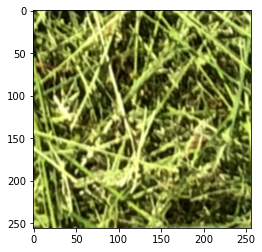

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Second recrop, first item:


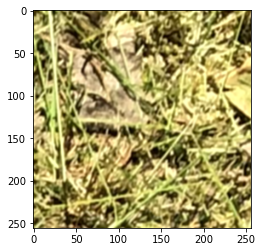

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Second recrop, second item:


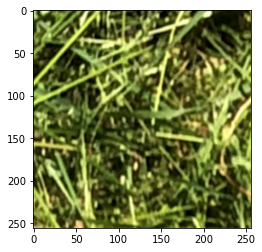

In [8]:
class RandomCropper:
    def __init__(self, dataset, first_seed = None):
        if first_seed is None:
            first_seed = int(str(int((datetime.utcnow() - datetime(1970, 1, 1)).total_seconds()*1_000_000))[::-1][:16])
        self.dataset_seeded = dataset.enumerate(first_seed)
    
    def recrop(self, size):
        cropped_dataset = self.dataset_seeded.map(lambda seed, image: tf.image.stateless_random_crop(image, (size, size, 3), [seed, 0]), num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
        self.dataset_seeded = self.dataset_seeded.map(lambda seed, image: (seed + self.dataset_seeded.cardinality(), image), num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
        return cropped_dataset
    
train_dataset_cropper = RandomCropper(train_dataset)
print("First recrop, first item:")
iterator = iter(train_dataset_cropper.recrop(train_image_cropped_size))
plt.imshow((next(iterator) + 1)/2)
plt.show()
print("Second recrop, first item:")
iterator = iter(train_dataset_cropper.recrop(train_image_cropped_size))
plt.imshow((next(iterator) + 1)/2)
plt.show()
print("Second recrop, second item:")
plt.imshow((next(iterator) + 1)/2)
plt.show()

## Generator model
Define the generator network